# VR - Motion recognition with simple gestures

## Libraries
* Numpy
* Pandas
* Matplotlib
* PyTorch

In [1]:
import os
from typing import Generator, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

## Importing scripts

In [2]:
from utils.data import Data

## Loading data

In [3]:
# Define base data directory
base_dir: str = os.path.join(os.getcwd(), 'data')

# Load data
tuple_data: tuple[np.ndarray, np.ndarray, np.ndarray] = Data.load_data(base_dir)

# Unpack data
data: np.ndarray = tuple_data[0]
labels: np.ndarray = tuple_data[1]
classes: np.ndarray = tuple_data[2]

## Data generator

In [4]:
def data_generator(X: np.ndarray, y: np.ndarray, batch_size: int=32) -> Generator:
    """
    Data generator for PyTorch.
    Params:
        X (np.ndarray): Data
        y (np.ndarray): Labels
        batch_size (int): Size of the batch, default to 32
    Returns:
        tuple[torch.Tensor, torch.Tensor]: Tuple containing the data and the labels
    """
    # Number of samples
    n_samples: int = X.shape[0]
    
    # Shuffle indices
    indices: np.ndarray = np.arange(n_samples)
    np.random.shuffle(indices)
    
    # Shuffle data
    X: np.ndarray = X[indices]
    y: np.ndarray = y[indices]
    
    # Iterate over the dataset
    for i in range(0, n_samples, batch_size):
        # Get batch data
        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        
        # Convert to torch tensors
        X_batch = torch.from_numpy(X_batch)
        y_batch = torch.from_numpy(y_batch)
        
        # Yield the batch
        yield X_batch, y_batch

## Model

In [5]:
def device() -> str:
    """
    Returns the device to use for training.
    Returns:
        device: str - Device to use for training
    """
    # Define CPU as default device
    device = "cpu"

    # Use Cuda acceleration if available (Nvidia GPU)
    if torch.cuda.is_available():
        device = "cuda:0"
    # Use Metal acceleration if available (MacOS)
    elif torch.backends.mps.is_available():
        device = "mps:0"
    
    return device

In [6]:
DEVICE = device()

In [7]:
class VRGestureRecognizer(nn.Module):
    def __init__(self, hidden_size: int, num_classes: int):
        super(VRGestureRecognizer, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(256*4*7, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 64)
        self.fc3 = nn.Linear(64, num_classes)

        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        # Pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Convolutional part
        out = self.maxpool(self.relu(self.conv1(x)))
        out = self.maxpool(self.relu(self.conv2(out)))
        out = self.maxpool(self.relu(self.conv3(out)))
        out = self.maxpool(self.relu(self.conv4(out)))

        # Flattening feature maps
        out = torch.flatten(out, 1)

        # Fully connected part    
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.softmax(self.fc3(out))
        
        return out
    

    def compile(self, optimizer, loss_fn):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
    
    def fit(self, X, y, epochs, batch_size, learning_rate) -> pd.DataFrame:
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        history = pd.DataFrame(columns=['Loss', 'Accuracy'])
        # Iterate over epochs
        for epoch in range(epochs):
            mean_loss = 0
            mean_acc = 0

            # Define a data generator
            data_gen = data_generator(X, y, batch_size=batch_size)
            n_batches = 0
            self.train()
            for i, batch in enumerate(data_gen):
                n_batches += 1
                # Get batch data
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device()).unsqueeze(1), y_batch.to(device())

                # Forward pass
                outputs = self(X_batch)
                loss = self.loss_fn(outputs, y_batch.long())
            
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update epoch loss
                mean_loss += loss.item()
                # Update epoch accuracy
                mean_acc += outputs.to('cpu').argmax(dim=1).eq(y_batch.to('cpu')).sum().item()

                # Compute mean loss and accuracy for the current epoch
            mean_loss /= n_batches
            mean_acc = mean_acc / (n_batches * batch_size)

            # Add epoch results to history
            history.loc[epoch] = [mean_loss, mean_acc]
        
            # Print epoch results
            print(f"Epoch [{epoch+1}/{epochs}] | Loss: {loss.item():.2f} | Accuracy: {mean_acc:.2f}")
            if mean_acc > 0.9:
                break
        
        return history
    
    def evaluate(self, X, y) -> tuple[float, float]:
        self.eval()
        with torch.no_grad():
            X = torch.from_numpy(X).to(device()).unsqueeze(1)
            y = torch.from_numpy(y).to(device())
            outputs = self(X)
            loss = self.loss_fn(outputs, y.long())
            acc = outputs.to('cpu').argmax(dim=1).eq(y.to('cpu')).sum().item() / X.shape[0]

            return loss, acc

Epoch [1/50] | Loss: 1.32 | Accuracy: 0.26
Epoch [2/50] | Loss: 1.43 | Accuracy: 0.30
Epoch [3/50] | Loss: 1.18 | Accuracy: 0.54
Epoch [4/50] | Loss: 1.41 | Accuracy: 0.54
Epoch [5/50] | Loss: 1.04 | Accuracy: 0.54
Epoch [6/50] | Loss: 1.13 | Accuracy: 0.54
Epoch [7/50] | Loss: 1.20 | Accuracy: 0.80
Epoch [8/50] | Loss: 0.96 | Accuracy: 0.80
Epoch [9/50] | Loss: 0.87 | Accuracy: 0.80
Epoch [10/50] | Loss: 0.84 | Accuracy: 0.80
Epoch [11/50] | Loss: 0.94 | Accuracy: 0.80
Epoch [12/50] | Loss: 1.03 | Accuracy: 0.80
Epoch [13/50] | Loss: 1.04 | Accuracy: 0.80
Epoch [14/50] | Loss: 1.03 | Accuracy: 0.80
Epoch [15/50] | Loss: 1.04 | Accuracy: 0.80
Epoch [16/50] | Loss: 0.93 | Accuracy: 0.80
Epoch [17/50] | Loss: 0.84 | Accuracy: 0.80
Epoch [18/50] | Loss: 0.93 | Accuracy: 0.80
Epoch [19/50] | Loss: 1.13 | Accuracy: 0.80
Epoch [20/50] | Loss: 0.94 | Accuracy: 0.80
Epoch [21/50] | Loss: 1.03 | Accuracy: 0.80
Epoch [22/50] | Loss: 1.03 | Accuracy: 0.80
Epoch [23/50] | Loss: 0.84 | Accuracy: 0.

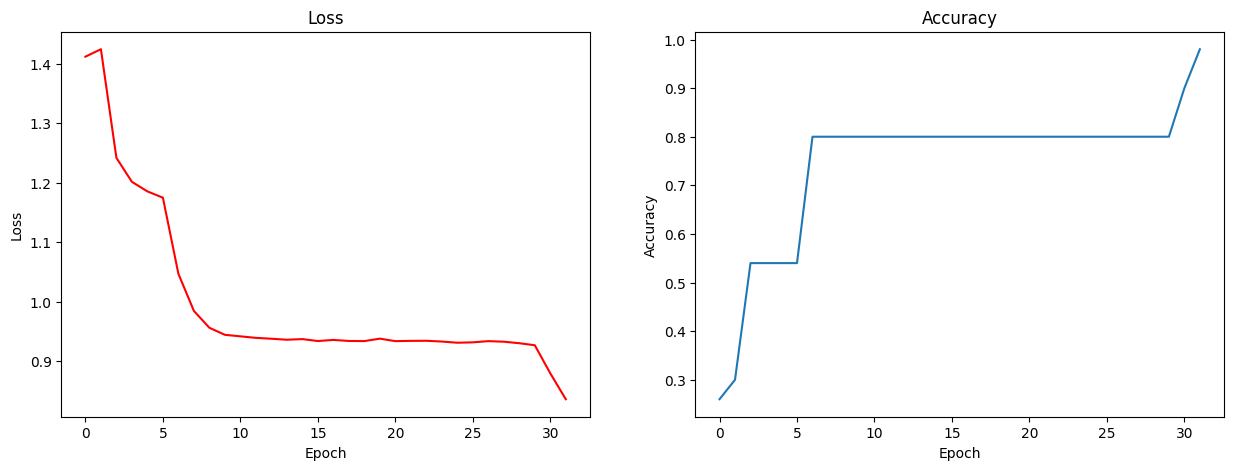

In [8]:
BATCH_SIZE = 10
EPOCHS = 50

gesture_recognizer = VRGestureRecognizer(hidden_size=128, num_classes=classes.shape[0]).to(device(), dtype=torch.float32)
optimizer = torch.optim.Adam(gesture_recognizer.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.15, random_state=42)

gesture_recognizer.compile(optimizer, loss_fn)
training_history = gesture_recognizer.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=1e-4)

def plot_history(history: pd.DataFrame) -> None:
    """
    Plot the training history. The history must be a dataframe with the following columns:
        - Loss
        - Accuracy
    Params:
        history (pd.DataFrame): Training history
    """
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(history['Loss'], color='red')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(history['Accuracy'])
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

    plt.show()

plot_history(history=training_history)

In [9]:
test_loss, test_accuracy = gesture_recognizer.evaluate(X_test, y_test)
print(f"Loss: {test_loss.item():.2f} | Accuracy: {test_accuracy:.2f}")

Loss: 0.80 | Accuracy: 1.00


In [10]:
import torch.onnx
def export_to_onnx(model, path: str) -> None:
    model.eval()
    X = torch.randn(BATCH_SIZE, 1, 71, 114, requires_grad=True)
    torch.onnx.export(model.to('cpu'), X, path, export_params=True, opset_version=10, do_constant_folding=True, input_names=['input'], output_names=['output'], dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})

export_to_onnx(gesture_recognizer, 'gesture_recognizer.onnx')

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

